# Inferring Transition Matrices with Uncertainty
*Authors: Eric Osband, Isuru Herath, Aashri Aggarwal*

<div>
    <c><img src="uncertainty.png" width="500"/></c>
</div>

---
### Outline
1. [Import Statements](#Import-Statements)
2. [Read in data](#Read-in-data)
3. [Calculate Transition Matrices](#Calculate-Transition-Matrices)
4. [Add Noise to Raw Counts](#Add-Noise-to-Raw-Counts)
5. [Count Investigation](#Count-Investigation)
6. [PCA Analysis & Visualization](#PCA-Analysis-and-Visualization)
7. [Feature Scoring](#Feature-Scoring)
---

## [Import Statements](#Outline)

In [1]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

import scipy as sp
from scipy.linalg import eig 
import matplotlib


from contextlib import suppress

import itertools

from tqdm import tqdm

from cassiopeia.Analysis import reconstruct_states
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.Analysis import small_parsimony
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
matplotlib.style.use('default')

## [Read in data](#Outline)

In [2]:
# Note: this function was modified from an existing module in Cassiopeia to suit our needs
def newick_to_network(newick_filepath, cm, f=1):
    """
	Given a file path to a newick file, convert to a directed graph.

	:param newick_filepath:
		File path to a newick text file
    :param cm:
        Character matrix (???)
	:param f:
		Parameter to be passed to Ete3 while reading in the newick file. (Default 1)
	:return: a networkx file of the tree
	"""

    G = nx.DiGraph()  # the new graph
    cm_lookup = cm.apply(lambda x: "|".join(x.values), axis=1)

    try:
        tree = Tree(newick_filepath, format=f)
    except:
        tree = Tree(newick_filepath)

    # Create dict from ete3 node to cassiopeia.Node
    e2cass = {}
    for n in tree.traverse("postorder"):

        if "|" in n.name:
            nn = Node("state-node", n.name.split("|"), support=n.support)
        elif n.name != "" or "Inner" in n.name:
            nn = Node(n.name, [], support=n.support)
        else:
            nn = Node("state-node", [], support=n.support)

        if n.is_leaf() and nn.char_string in cm_lookup:
            nn.is_target = True

        e2cass[n] = nn
        G.add_node(nn)

    for p in tree.traverse("postorder"):

        pn = e2cass[p]

        for c in p.children:
            cn = e2cass[c]

            G.add_edge(pn, cn)

    return G

In [3]:
# Read in trees from newick format files

lg_meta = pd.read_csv("./data/GSM4905335_meta.5k.tsv", sep='\t', index_col = 0)
home_dir = './data/trees/'

# Lg: tree number
lg_to_tree = {}  # Will store map of tree number to NetworkX tree
lg_to_cm = {}    # Will store map of tree number to character matrix
for fp in tqdm(os.listdir(home_dir)):
    if "tree_hybrid_priors.alleleThresh.processed.txt" not in fp:
        continue
    
    lg = fp.split("_")[1][2:]
        
    cmfp = "./data/character_matrices/" + fp.replace("tree_hybrid_priors", "character_matrix").replace(".processed","")
    cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
    
    fp = home_dir + fp    
    
    # From other file
    tree = Cassiopeia_Tree('from_newick', network = newick_to_network(fp, cm))
    lg_to_tree[int(lg)] = tree.post_process(cm)
    
    lg_to_cm[int(lg)] = cm
    
print("Number of trees loaded", len(os.listdir(home_dir)))

100%|█████████████████████████████████████████| 245/245 [00:31<00:00,  7.84it/s]

Number of trees loaded 245


In the code above, which was adapted from the original infer transition matrices notebook code, we read in the newick trees from the specified directories along with their metadata and reconstruct them in NetworkX format. At the end, we output two dictionaries, one being a map of tree numbers to these NetworkX trees, and the second being a map of tree numbers to their individual character matrices.

Now that we have our trees and metadata loaded in, we can run FitchCount and form our transition matrices.

## [Calculate Transition Matrices](#Outline)
In this section, we run the FitchCount algorithm to calculate the number of tissue to tissue transitions for each tree phylogeny. We then turn those into raw counts into conditional probabilities using k-smoothing and adding in noise for further analysis.

**Raw Count Arrays**

In [4]:
def get_count_arrs():
    '''
    Returns a tuple of (lgs, count_arrs) where lgs is the list if LineageGroup identifiers corresponding to the 
    count arrays and each count_arr it the output of the FitchCount algorithm representing the transition
    counts between each of the 6 tissue locations.
    '''
    lgs = []
    count_arrs = []
    for _lg in tqdm(lg_to_tree.keys()):
        
        tree = lg_to_tree[_lg]
        cm = lg_to_cm[_lg]

        plg = tree.post_process(cm).network

        count_arr = reconstruct_states.fitch_count(plg, lg_meta['sampleID'])
        count_arrs.append(count_arr)
        lgs.append(_lg)
    return lgs, count_arrs

In [5]:
lgs, count_arrs = get_count_arrs()

100%|███████████████████████████████████████████| 82/82 [02:58<00:00,  2.17s/it]


In [6]:
def plot_count_arr(count_arr, with_mask = False, ax=None):
    '''
    Visualizes count array with labeled axes. Arguments:
        count_arr: array to visualize
        with_mask: true if diagonal values should be masked
        ax: axis to plot on
    '''
    if ax is None:
        ax = plt.gca()
#     res = count_arr.loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
    mask = np.eye(6) if with_mask else None
    g = sns.heatmap(count_arr, mask = mask, cmap="Reds", square=True, ax=ax, cbar=True)
    return g

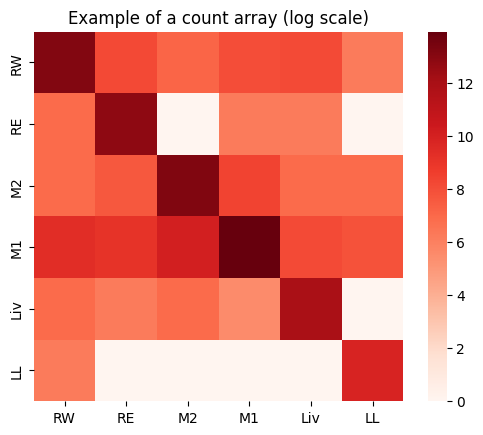

In [7]:
plot_count_arr(np.log(count_arrs[0] + 1))
plt.title("Example of a count array (log scale)")
plt.show()

**Conditional Probability Matrices**

In [8]:
def plus_k_counting(x, k):
    '''
    Applies plus-k pseudocount normalization to an array x. Arguments:
        x: array to normalize
        k: k smoothing value. If k is zero, normalizes to 1. 
    '''
    if k == 0:
        return x / max(x.sum(), 1)
    return (x + k) / (x.sum() + x.shape[0] * k)
def get_conditional_prob_matrices(count_arrs, k=0):
    '''
    Gets k-pseudo count conditional probability matrices from the given count arrays.
    '''
    conditional_prob_matrices = []
    for count_arr in count_arrs:
        conditional_prob_matrices.append(count_arr.apply(plus_k_counting, axis=1, args=(k,)) )
    return conditional_prob_matrices

In [9]:
# K values to expirement with
ks = [0, 0.001, 0.01, 0.1, 1.0]

# Masked refers to whether the diagonal elements are "masked" (set to zero)
count_arrs_unmasked = count_arrs
count_arrs_masked = [arr * (1-np.eye(6)) for arr in count_arrs]

# Calculate conditional probability matrices
conditional_prob_matrices = get_conditional_prob_matrices(count_arrs_masked, 0)
conditional_prob_matrices_point1 = get_conditional_prob_matrices(count_arrs_masked, 0.1)

In [10]:
def plot_trans_matrix(count_arr, vmin=0, vmax=1.0, ax=None):
    '''
    Vizualizes the conditional probability transition matrix, similar to plot_count_arr above. 
    Additional arguments:
        vmin: min value to map to color
        vmax: max value to map to color
    '''
    if ax is None:
        ax = plt.gca()
#     res = count_arr.loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
    g = sns.heatmap(count_arr, mask = np.eye(6), cmap="Reds", square=True, ax=ax, vmin = vmin, vmax=vmax, cbar=True)
    return g

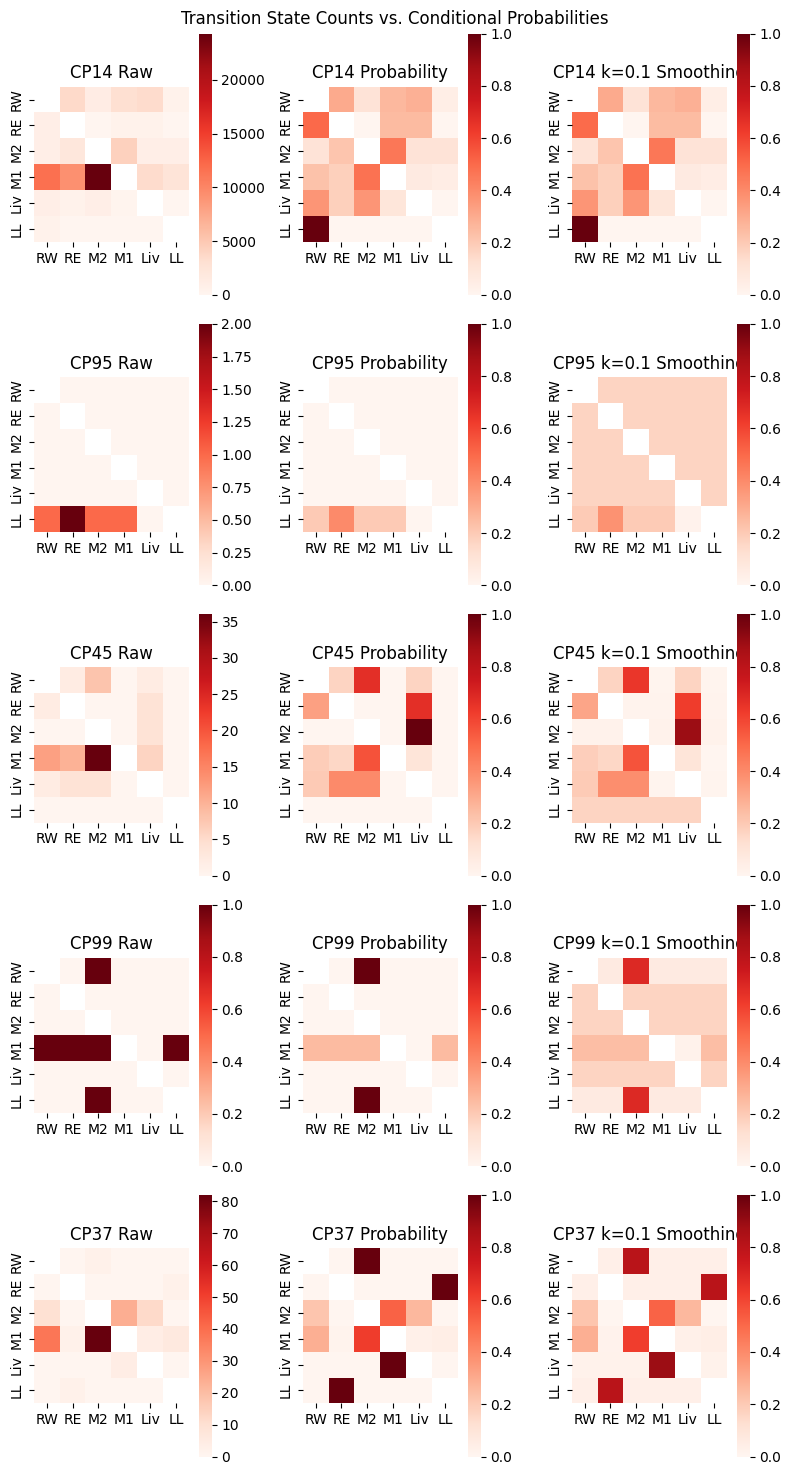

In [11]:
# Plot some conditional probability matrices to see how k-smoothing affects it
fig, axs = plt.subplots(5,3, figsize=(8,15))

for i in range(5):
    lg = lgs[i]
    count_arr = count_arrs[i]
    tmat_0 = conditional_prob_matrices[i]
    tmat_point1 = conditional_prob_matrices_point1[i]

    plot_trans_matrix(count_arr, vmin=0, vmax=np.max((1 - np.eye(6)) * count_arr.values), ax=axs[i][0])
    plot_trans_matrix(tmat_0, ax=axs[i][1])
    plot_trans_matrix(tmat_point1, ax=axs[i][2])
    axs[i][0].set_title("CP%d Raw" % lg)
    axs[i][1].set_title("CP%d Probability" % lg)
    axs[i][2].set_title("CP%d k=0.1 Smoothing" % lg)
        
fig.suptitle("Transition State Counts vs. Conditional Probabilities")
fig.tight_layout()
plt.show()

We can see above how the raw counts propagate into conditional probabilities, and the reason smoothing may help. Notably, in the second to last graph of CP99, we see how observing single counts of a few transitions vastly skews the conditional probabilities in the unsmoothed transition matrix, especially when juxtaposed with transition matrices based on higher observed counts. **Our hypothesis was that these cells with few counts may be misleading the original PCA analysis performed by Quinn et al. by inducing large amounts of variance in these conditional probabilities.** 
We investigate this hypothesis and the quantitative effects of low counts in the coming analysis.

## [Add Noise to Raw Counts](#Outline)
We have already implemented one smoothing technique - k-smoothing - and we now go on to another, namely adding noise into the original count matrices.

To do this, we consider each raw transition count matrix as a realization of 30 independent Poisson processes. For each origin tissue $i$, we assume there is a rate $\lambda_{ij}$ at which cells can metastasize to tissue $j$ ($i \neq j$) over a certain time period. We use MLE to estimate $\lambda_{ij}$ from the existing count matrix, and then resample each one $n=50$ times according to this distribution. In total, then, we yield $82*50 = 4100$ samples for analysis, rather than the original $82$.  

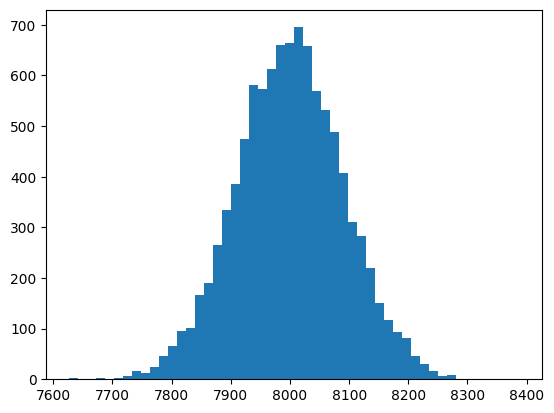

In [12]:
# First, a visualization of the Poisson process
plt.hist(np.random.poisson(8000, (10000,)), bins=50)
plt.show()

In [13]:
def sample_noisy_tmat(tmat):
    ''' 
    Returns a single "noisy" transition matrix using MLE parameters from tmat. 
    Each nondiagonal value is sampled from its own distribution.
    Each diagonal value is the same as what is in tmat.
    '''
    tmat_masked = tmat * (1-np.eye(tmat.shape[0]))
    tmat_sample = np.random.poisson(tmat_masked, tmat.shape) 
    tmat_sample = tmat_sample + tmat * np.eye(tmat.shape[0])
    return tmat_sample

def get_noisy_tmats(tmat, n=50):
    '''
    Returns n noisy transition matrices by sampling from the distributions which created tmat.
    
    In this case, we generate each non-diagonal entry via a poisson process with parameters t and 
    lambda derived via MLE from the entries in tmat. 
    '''
    tmat_masked = tmat * (1-np.eye(tmat.shape[0]))
    
    if tmat_masked.values.max() > 10e80:
        # If the largest value is over a threshold, we can't directly sample a Poisson distribution, so 
        # we instead only resample the smaller values and keep the larger ones as is.
        # Since these will be turned into conditional probabilities, this should not affect much.
        large_value_mask = tmat_masked.values > 10e80
        tmat_large = tmat_masked * large_value_mask
        tmat_reduced = tmat_masked - tmat_large
        return [sample_noisy_tmat(tmat_reduced) + tmat_large for i in range(50)]

    return [sample_noisy_tmat(tmat) for i in range(50)]

def get_noisy_data(lgs, tmats, n=50):
    '''
    Returns a dictionary of lineage group marker lg to n noisy transition matrices sampled from the 
    originally observed transition matrix.
    '''
    new_tmats = {}
    for i in range(len(lgs)):
        new_tmats[i] = get_noisy_tmats(tmats[i], n)
    return new_tmats

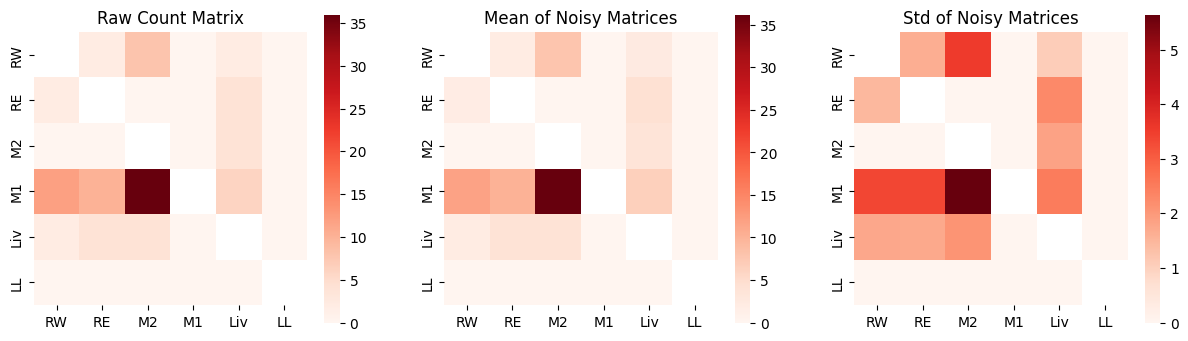

In [14]:
# Example of random Poisson sampling
count_arrs_with_noise = get_noisy_data(lgs, count_arrs_unmasked)
count_arrs_with_noise_flat = []
for elem in count_arrs_with_noise.values():
    count_arrs_with_noise_flat += elem

fig, axs = plt.subplots(1,3, figsize=(15,4))
matrix = count_arrs[2] * (1 - np.eye(6))
samples = get_noisy_tmats(matrix)
plot_count_arr(matrix, True, axs[0])
plot_count_arr(pd.DataFrame(np.mean(samples, axis=0), columns=matrix.columns, index=matrix.index), True, axs[1])
plot_count_arr(pd.DataFrame(np.std(samples, axis=0), columns=matrix.columns, index=matrix.index), True, axs[2])
axs[0].set_title("Raw Count Matrix")
axs[1].set_title("Mean of Noisy Matrices")
axs[2].set_title("Std of Noisy Matrices")
plt.show()

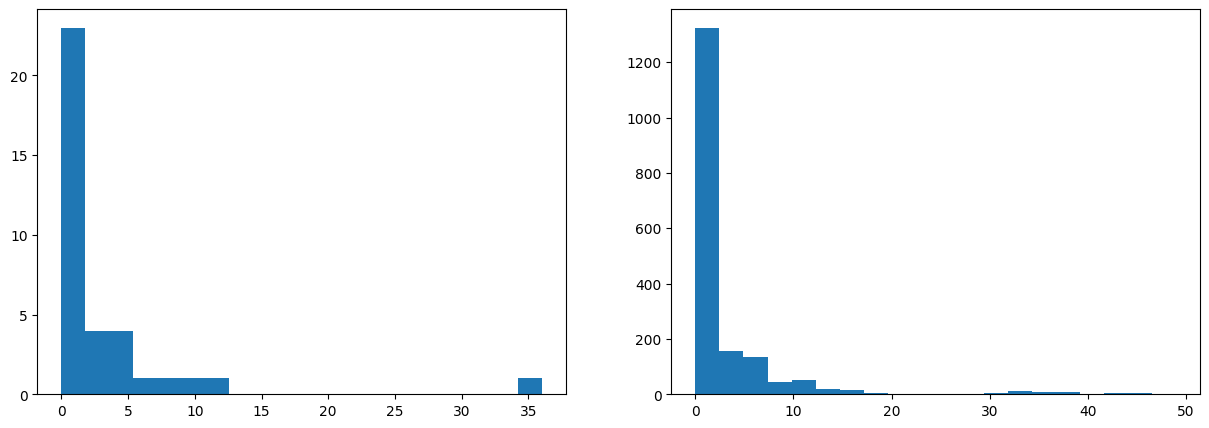

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.hist(matrix.values.reshape(-1,1), bins=20)
ax2.hist(np.array(samples).reshape(-1,1), bins=20)
plt.show()

# [Count Investigation](#Outline)
Before running dimensionality reduction, we did some more exploratory data analysis on the distribution of transition counts across cells.

In [16]:
count_arrs = count_arrs_unmasked

/opt/anaconda3/envs/CS4775/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


Fraction of data with max_count<10: 43.902 percent
Fraction of data with max_count<1: 23.171 percent


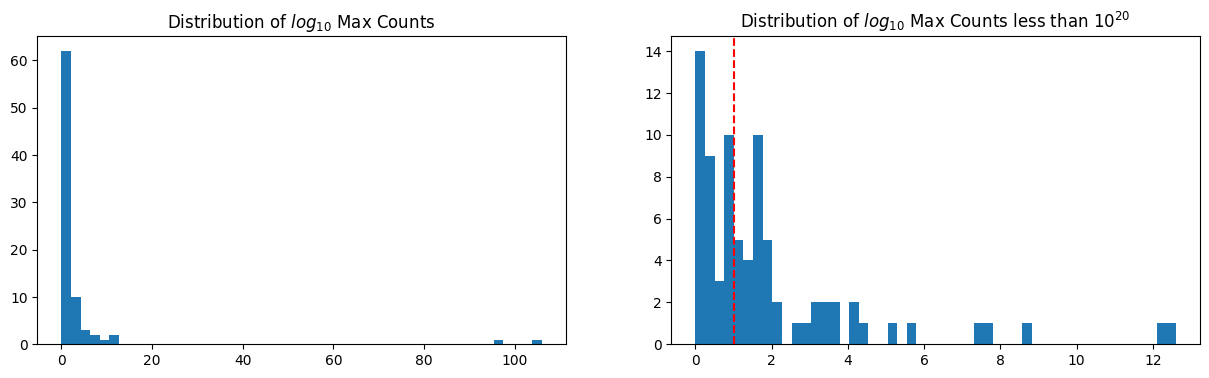

In [17]:
fig, axs = plt.subplots(1,2, figsize=(15,4))
max_counts = np.array([max(np.max(count_arr * (1 - np.eye(6))).max(), 1) for count_arr in count_arrs])
max_counts = np.log(max_counts) / np.log(10) # Take log base 10 of these counts to condense data for the histogram
axs[0].hist(max_counts, bins=50)
axs[1].hist(max_counts[max_counts < 20], bins=50)
axs[1].axvline(1, linestyle="dashed", c = "red")
proportion_10 = np.sum(max_counts <= 1) / len(max_counts)
proportion_1 = np.sum(max_counts <= np.log(2) / np.log(10)) / len(max_counts)
print("Fraction of data with max_count<10: %.3f percent" % (proportion_10*100))
print("Fraction of data with max_count<1: %.3f percent" % (proportion_1*100))
axs[0].set_title(r"Distribution of $log_{10}$ Max Counts")
axs[1].set_title(r"Distribution of $log_{10}$ Max Counts less than $10^{20}$")
plt.show()

**TODO: more when writing paper perhaps, like analyzing mean and std variation**

## [PCA Analysis and Visualization](#Outline)
In this section, we flatten the transition matrices computed above into 43-dimensional feature vector per cell, and then apply PCAs on this DataFrame to determine variance-causing trends of transitions across cells.

In [18]:
# Set transition labels to be used universally
trans_labels = []
toy = count_arrs[1]
for i in range(toy.shape[0]):
    for j in range(toy.shape[1]):
        if i != j:
            trans_labels.append(toy.index.values[i] + "->" + toy.columns.values[j])

trans_labels.append("LLReseeding")
trans_labels.append("To_M")
trans_labels.append('To_Liv')
trans_labels.append('LL_to_RL')
trans_labels.append("RL_to_LL")
trans_labels.append("IntraLung")
trans_labels.append('IntraM')
trans_labels.append('ToRL')
trans_labels.append("PrimarySeeding")
trans_labels.append("FromM1")
trans_labels.append("FromM2")
trans_labels.append("FromMed")

In [19]:
memoization = {}
def get_pcas_from_tmats(tmats, count_arrs):
    transition_vectors = []
    transition_vectors_counts = []
    k = 0
    for i in range(len(tmats)):
        lg, tm, count_arr = 0, tmats[i], count_arrs[i]
        
        # Create two vectors: One of transition probabilities (tv) and one for the counts those numbers were based on
        tv = []
        tv_counts = []

        for i in range(tm.shape[0]):
            for j in range(tm.shape[1]):
                if i != j:    
                    tv.append(tm.iloc[i, j])
                    tv_counts.append(count_arr.iloc[i, j])
                    
        np.fill_diagonal(tm.values, 0)
        np.fill_diagonal(count_arr.values, 0)
        
        tv.append(np.sum(tm['LL'].values))
        tv.append(np.sum(tm[['M1', 'M2']].sum()))
        tv.append(np.sum(tm['Liv'].values))
        tv.append(np.sum(tm.loc['LL', ['RW', 'RE']].sum()))
        tv.append(np.sum(tm.loc[['RE', 'RW'], 'LL'].sum()))
        tv.append(np.sum(tm.loc[['LL', "RE", "RW"], ['LL', 'RE', 'RW']].sum()))
        tv.append(np.sum(tm.loc[['M1', 'M2'], ['M1', 'M2']].sum()))
        tv.append(np.sum(tm[['RE', 'RW']].sum()))
        
        tv_counts.append(np.sum(count_arr['LL'].values))
        tv_counts.append(np.sum(count_arr[['M1', 'M2']].sum()))
        tv_counts.append(np.sum(count_arr['Liv'].values))
        tv_counts.append(np.sum(count_arr.loc['LL', ['RW', 'RE']].sum()))
        tv_counts.append(np.sum(count_arr.loc[['RE', 'RW'], 'LL'].sum()))
        tv_counts.append(np.sum(count_arr.loc[['LL', "RE", "RW"], ['LL', 'RE', 'RW']].sum()))
        tv_counts.append(np.sum(count_arr.loc[['M1', 'M2'], ['M1', 'M2']].sum()))
        tv_counts.append(np.sum(count_arr[['RE', 'RW']].sum()))


        tot = count_arr.sum().sum()
        tot = max(tot, 1)
    
        # Add additional conditional probabilities (not from the raw transition matrix)
        LL_density = np.sum(count_arr.loc['LL',:]) / tot
        M1_density = np.sum(count_arr.loc['M1',:]) / tot
        M2_density = np.sum(count_arr.loc['M2',:]) / tot
        
        tv.append(LL_density)
        tv.append(M1_density)
        tv.append(M2_density)
        tv.append(M1_density + M2_density)
        
        tv_counts.append(LL_density * tot)
        tv_counts.append(M1_density * tot)
        tv_counts.append(M2_density * tot)
        tv_counts.append((M1_density + M2_density) * tot)
        
        transition_vectors.append(np.nan_to_num(tv))
        transition_vectors_counts.append(np.nan_to_num(tv_counts))

        k += 1

    tmat = np.array(transition_vectors)
    tmat_counts = np.array(transition_vectors_counts)


    tmat = pd.DataFrame(tmat, columns=trans_labels)
    tmat_counts = pd.DataFrame(tmat_counts, columns=trans_labels)

    tmat_z = tmat \
        .subtract(tmat.mean(axis=1), axis=0) \
        .divide(tmat.std(axis=1), axis=0)

    
    tmat_z = np.nan_to_num(tmat_z)

    pca = PCA()
    tmat_transformed = pca.fit_transform(tmat_z)
    return pca, tmat_z, tmat_transformed, tmat_counts

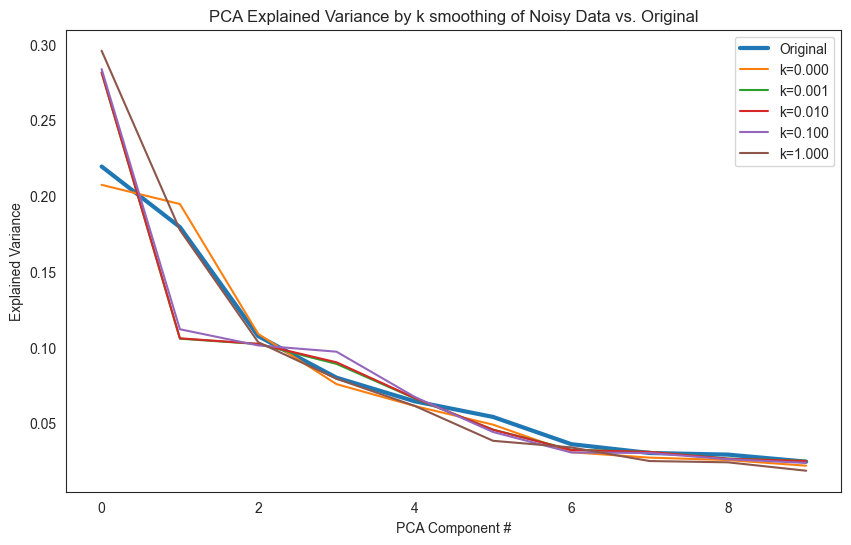

CPU times: user 2min 23s, sys: 2.74 s, total: 2min 26s
Wall time: 2min 22s


In [35]:
%%time
fig, axs = plt.subplots(1, figsize=(10,6))
conditional_ps = get_conditional_prob_matrices(count_arrs_masked, k=0)
pca, _, _, _ = get_pcas_from_tmats(conditional_ps, count_arrs_masked)
plt.plot(pca.explained_variance_ratio_[:10], alpha=1, label="Original", linewidth=3)

for i in range(len(ks)):
    k_arg = ks[i]
    conditional_ps_n = get_conditional_prob_matrices(count_arrs_with_noise_flat, k=k_arg)
    pca_n, _, _, _ = get_pcas_from_tmats(conditional_ps_n, count_arrs_with_noise_flat)
    plt.plot(pca_n.explained_variance_ratio_[:10], alpha=1, label="k=%.3f" % k_arg)
    

plt.title("PCA Explained Variance by k smoothing of Noisy Data vs. Original")
plt.ylabel("Explained Variance")
plt.xlabel("PCA Component #")
plt.legend()
plt.show()

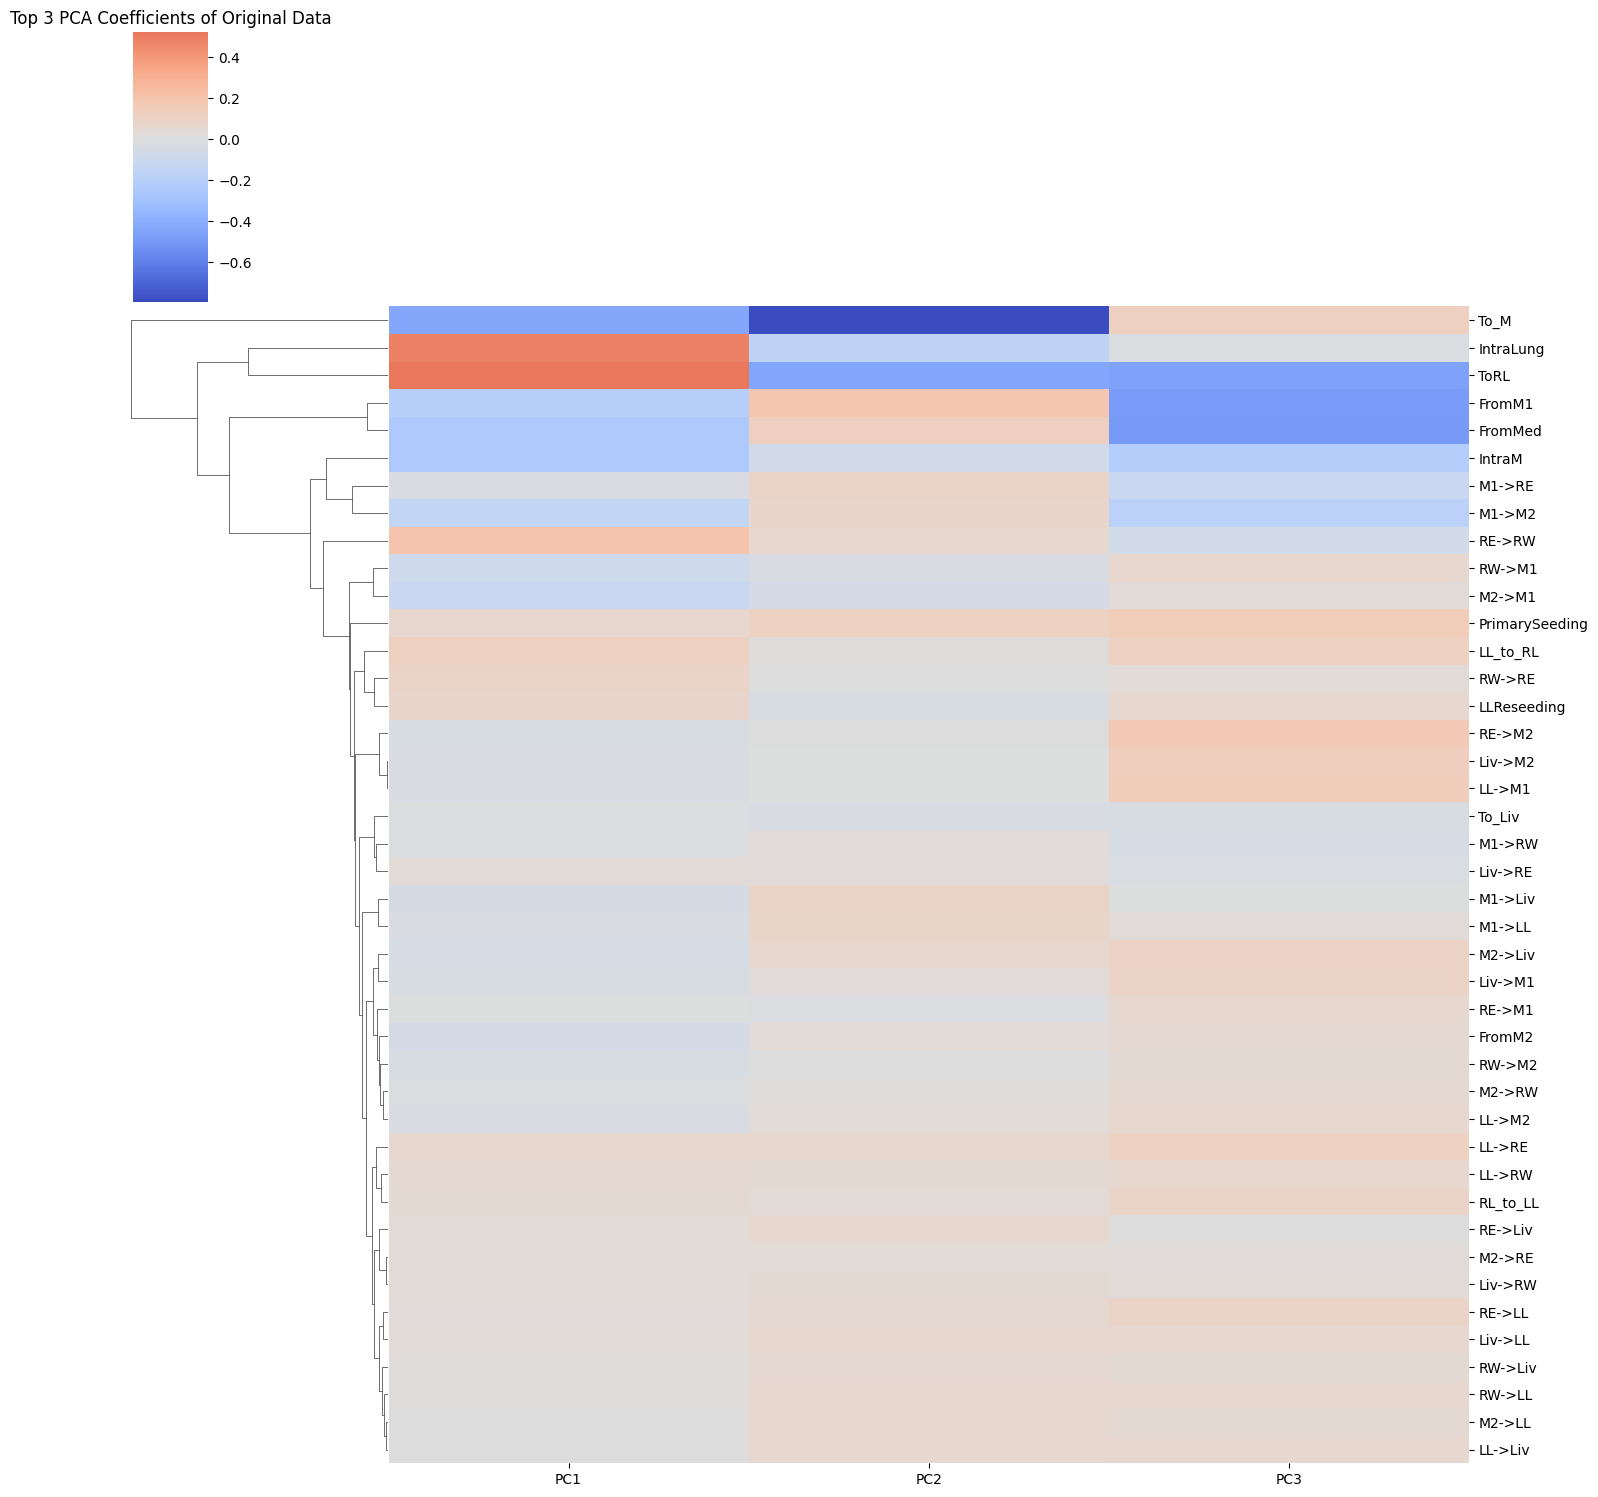

In [21]:
conditional_ps = get_conditional_prob_matrices(count_arrs_masked, k=0)
pca, _, tmat_transformed, _ = get_pcas_from_tmats(conditional_ps, count_arrs_masked)

coeff = np.transpose(pca.components_)
coeffdf = pd.DataFrame(coeff, index=trans_labels)
coeffdf.columns = ["PC" + str(x + 1) for x in range(coeff.shape[1])]

cm = sns.clustermap(coeffdf.iloc[:, :3], cmap = 'coolwarm', col_cluster=False, figsize = (15, 15), center=0)

plt.title("Top 3 PCA Coefficients of Original Data")
plt.show()

In [22]:
def plot_pca_samples(pca, tmat_transformed, k_arg, ax, d1=0, d2=1, original_count_arrs=None):
    sns.set_style("white")

    x, y = tmat_transformed[:,d1], tmat_transformed[:, d2]

    labs = lgs

    scalex = 1.0/(x.max() - x.min())
    scaley = 1.0/(y.max() - y.min())
    

    sns.scatterplot(x=x*scalex, y=y*scaley, ax=ax, s=20, label="Noisy Data")
    ax.set_title("PCA of Transition Matrices k=%.3f" % k_arg)


    if original_count_arrs is not None:
        conditional_ps_true = get_conditional_prob_matrices(original_count_arrs, k=k_arg)
        _, tmat_z_true, _, _ = get_pcas_from_tmats(conditional_ps_true, original_count_arrs)
        tmat_true_transformed = pca.transform(tmat_z_true)
        x, y = tmat_true_transformed[:,d1], tmat_true_transformed[:, d2]
        
        scalex = 1.0/(x.max() - x.min())
        scaley = 1.0/(y.max() - y.min())
        sns.scatterplot(x=x*scalex, y=y*scaley, ax=ax, color="red", s=50, marker="X", label="Original Smoothed Data")

    ax.set_xlabel("PC{} ({}% Explained)".format(d1+1, round(pca.explained_variance_ratio_[d1]*100,1)))
    ax.set_ylabel("PC{} ({}% Explained)".format(d2+1, round(pca.explained_variance_ratio_[d2]*100,1)))
    ax.legend()

def plot_pca_arrows(pca, k_arg, ax, d1=0, d2=1):
    coeff = np.transpose(pca.components_)

    iis1 = np.argsort(np.abs(coeff[:, d1]))[::-1][:5]
    iis2 = np.argsort(np.abs(coeff[:, d2]))[::-1][:5]
    iis = np.unique(np.concatenate((iis1, iis2)))
    for i in iis:
        if i in iis1:
            c = "blue"
        else:
            c = "orange"
        ax.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = c,alpha = 0.5)
        ax.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, trans_labels[i], fontsize=8, color = c, ha = 'center', va = 'center')

    ax.set_xlim(-0.8, 0.8)
    ax.set_ylim(-0.9, 0.8)

    ax.set_title("k=%.3f Top Coeffs" % k_arg)
    ax.set_xlabel("PC{} ({}% Explained)".format(d1+1, round(pca.explained_variance_ratio_[d1]*100,1)))
    ax.set_ylabel("PC{} ({}% Explained)".format(d2+1, round(pca.explained_variance_ratio_[d2]*100,1)))



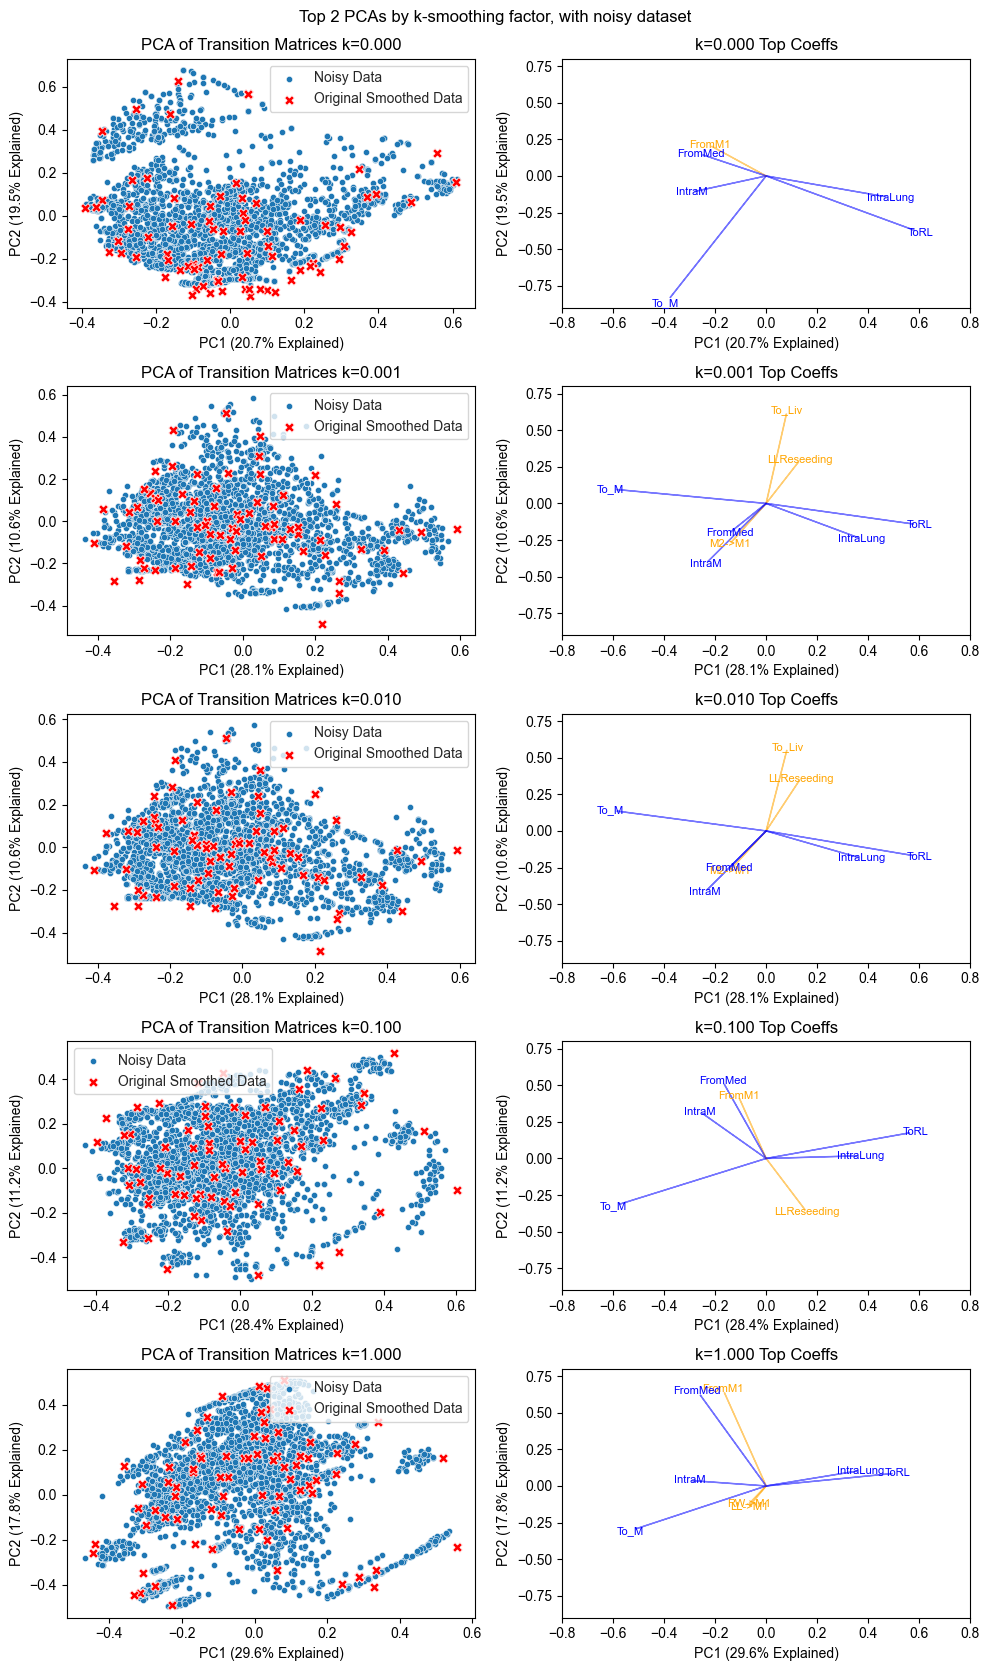

In [23]:
fig, axs = plt.subplots(len(ks), 2, figsize=(10, 17))
fig.suptitle("Top 2 PCAs by k-smoothing factor, with noisy dataset\n")
for i in range(len(ks)):
    k_arg = ks[i]
    ax1, ax2 = axs[i]
    conditional_ps = get_conditional_prob_matrices(count_arrs_with_noise_flat, k=k_arg)
    pca, _, tmat_transformed, _ = get_pcas_from_tmats(conditional_ps, count_arrs_with_noise_flat)

    plot_pca_samples(pca, tmat_transformed, k_arg, ax1, d1=0, d2=1, original_count_arrs=count_arrs_masked)

    plot_pca_arrows(pca, k_arg, ax2, d1=0, d2=1)
fig.tight_layout()
plt.show()

## [Feature Scoring](#Outline)
Now that we have calculated our Principal Components for each of our sets of count arrays, we can assess the extent to which they highlight similar features. To do this, we first construct a single PCA vector from the top 3 PCAs of each dataset by summing the squared values element-wise, resulting in a 42 dimensional vector that gives us a sense of how much weight each feature carries across all three top principal components. From there, we assess similarity in two ways.

First, we establish a similarity function to relate the two aggregated PCA vectors. We chose to use cosine similarity as this function, which is just in a sense a normalized dot product. This provides a value between 0 and 1 representing how similar the two vectors are at representing all features.

Second, we calculate a raw overlap of the features that appear in the top 10 components across both vectors, and call those the "uncertainty-resilient features". 

In [24]:
def abs_cosine_similarity(a, b):
    '''
    Returns the cosine similarity of the absolute values of a and b
    '''
    return np.dot(np.abs(a),np.abs(b)) / np.linalg.norm(a) / np.linalg.norm(b)
def get_top_pca_vector(pca):
    '''
    Computes a single vector holding an aggregate weight of each feature across the top three principal
    components. At a high level, it computes an "importance" of each feature among the top three PCAs. 
    '''
    return (pca.components_[:3, :] ** 2).sum(axis=0)

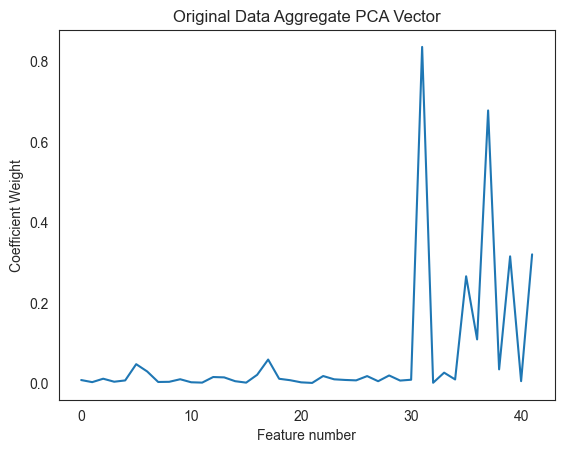

In [25]:
conditional_ps_true = get_conditional_prob_matrices(count_arrs_masked, k=0)
original_pca, _, _, _ = get_pcas_from_tmats(conditional_ps_true, count_arrs_masked)
original_pca_vector = get_top_pca_vector(original_pca)
plt.plot(original_pca_vector)
plt.title("Original Data Aggregate PCA Vector")
plt.xlabel("Feature number")
plt.ylabel("Coefficient Weight")
plt.show()

In [ ]:
### fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(original_pca_vector, label="Original", linewidth=3)
for i in range(len(ks)):
    k_arg = ks[i]
    conditional_ps = get_conditional_prob_matrices(count_arrs_with_noise_flat, k=k_arg)
    pca, _, tmat_transformed, _ = get_pcas_from_tmats(conditional_ps, count_arrs_with_noise_flat)
    pca_vector = get_top_pca_vector(pca)
    ax.plot(pca_vector, label="Noisy k=%.3f" % k_arg, alpha=.8)
    print("Cosine similarity of top three PCAs at k=%.3f: %.6f" % (k_arg, abs_cosine_similarity(original_pca_vector, pca_vector)))

plt.xlabel("Feature number")
plt.ylabel("Coefficient Weight")
plt.title("Aggregate PCA Coefficients Across Datasets")
plt.legend()
plt.show()
    

In [27]:
def get_top_10_features(pca_vector):
    return {trans_labels[i]:pca_vector[i] for i in np.argsort(pca_vector)[-10:]}
def get_feature_overlap(pca_vector_1, pca_vector_2):
    features1 = get_top_10_features(pca_vector_1)
    features2 = get_top_10_features(pca_vector_2)
    return set(features1.keys()).intersection(set(features2.keys()))

In [28]:
get_top_10_features(original_pca_vector)

{'RE->M2': 0.030064720378927386,
 'PrimarySeeding': 0.03525072939858487,
 'RE->RW': 0.04815116387807659,
 'M1->M2': 0.05964807396120317,
 'IntraM': 0.10962289294403738,
 'IntraLung': 0.266165471519989,
 'FromM1': 0.31564405156208486,
 'FromMed': 0.3205602739336219,
 'ToRL': 0.677573015835916,
 'To_M': 0.8351527580106564}

In [29]:
all_overlap_features = []
all_noisy_features = set()
for k in ks:
    conditional_ps = get_conditional_prob_matrices(count_arrs_with_noise_flat, k=k)
    pca, _, tmat_transformed, _ = get_pcas_from_tmats(conditional_ps, count_arrs_with_noise_flat)
    noisy_pca_vector = get_top_pca_vector(pca)
    overlap_features = get_feature_overlap(original_pca_vector, noisy_pca_vector)
    all_overlap_features += overlap_features
    all_noisy_features = all_noisy_features.union(get_top_10_features(noisy_pca_vector).keys())
    print("k=%.3f overlap features:" % k, overlap_features)
    
feature_counts = dict(zip(*np.unique(all_overlap_features, return_counts=True)))
print("Feature presence counts", feature_counts)
not_present_in_noisy_data = set(get_top_10_features(original_pca_vector).keys()).difference(all_noisy_features)
print("Original features not seen in noisy data:", not_present_in_noisy_data)

k=0.000 overlap features: {'IntraLung', 'PrimarySeeding', 'To_M', 'IntraM', 'RE->RW', 'FromM1', 'FromMed', 'M1->M2', 'ToRL'}
k=0.001 overlap features: {'IntraLung', 'To_M', 'IntraM', 'FromM1', 'FromMed', 'ToRL'}
k=0.010 overlap features: {'IntraLung', 'To_M', 'IntraM', 'FromM1', 'FromMed', 'ToRL'}
k=0.100 overlap features: {'IntraLung', 'To_M', 'IntraM', 'FromM1', 'FromMed', 'M1->M2', 'ToRL'}
k=1.000 overlap features: {'IntraLung', 'To_M', 'IntraM', 'FromM1', 'FromMed', 'ToRL'}
Feature presence counts {'FromM1': 5, 'FromMed': 5, 'IntraLung': 5, 'IntraM': 5, 'M1->M2': 2, 'PrimarySeeding': 1, 'RE->RW': 1, 'ToRL': 5, 'To_M': 5}
Original features not seen in noisy data: {'RE->M2'}


As you can see, many features appear in all smoothing samples, but some only showed up in the k=0 noisy set, and one never showed up at all.

In contrast, Quinn et al.'s original paper reported "FromMed", "Intra_M", "PrimarySeeding", "IntraLung", "ToRL", and "To_M" as the top performing features. While mostly overlapping - which is good - we do see see an absence of two of these features, "PrimarySeeding" and "FromMed", suggesting they may have been flagged originally due to small counts. Let's see how the original counts were distributed to confirm.

In [30]:
conditional_ps_true = get_conditional_prob_matrices(count_arrs_masked, k=0)
_, _, _, original_tmat_counts = get_pcas_from_tmats(conditional_ps_true, count_arrs_masked)


/var/folders/17/r5bmb4d97vjcyp6740jnx5yw0000gn/T/ipykernel_28861/2186356428.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax1.hist(np.log(original_tmat_counts[not_present_in_noisy_data][original_tmat_counts < 10e90] + 1) / np.log(10), label=list(not_present_in_noisy_data))


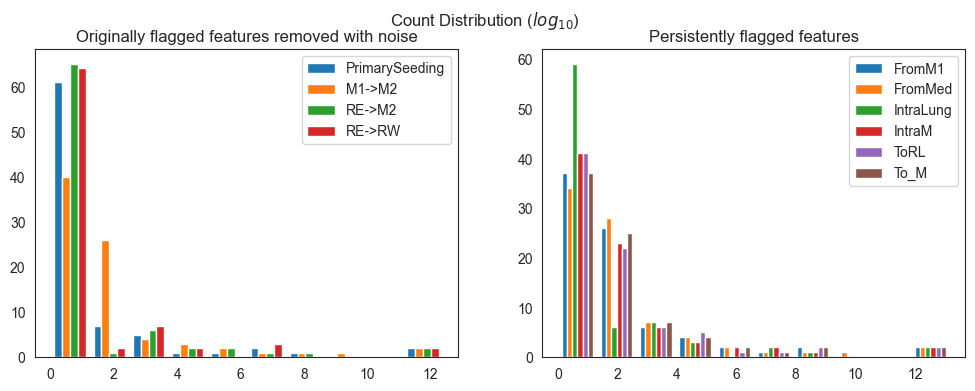

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

all_overlap_features = []
for f,c in feature_counts.items():
    if c < 4:
        not_present_in_noisy_data.add(f)
    else:
        all_overlap_features.append(f)
        
ax1.hist(np.log(original_tmat_counts[not_present_in_noisy_data][original_tmat_counts < 10e90] + 1) / np.log(10), label=list(not_present_in_noisy_data))


ax2.hist(np.log(original_tmat_counts[all_overlap_features][original_tmat_counts < 10e90] + 1) / np.log(10), label=list(all_overlap_features))
fig.suptitle(r"Count Distribution ($log_{10}$)")
ax1.set_title("Originally flagged features removed with noise")
ax2.set_title("Persistently flagged features")

ax1.legend()
ax2.legend()
plt.show()

As we can see, then, there are very low and isolated counts for each of these features that were originally identified for having high variance between lineage groups, while the features that persisted through our analysis had much better spread out distributions, which is likely why they made it through our noise additions. 

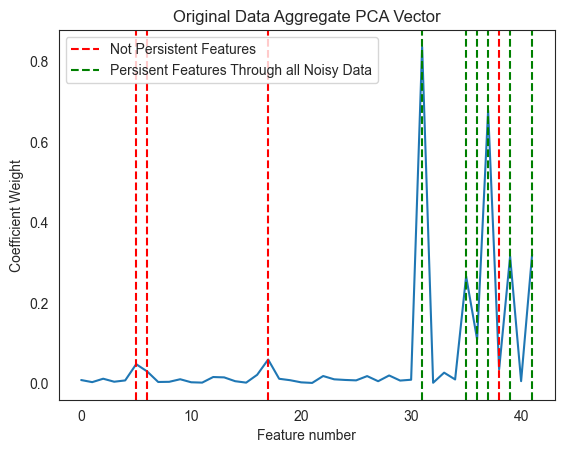

In [32]:
conditional_ps_true = get_conditional_prob_matrices(count_arrs_masked, k=0)
original_pca, _, _, _ = get_pcas_from_tmats(conditional_ps_true, count_arrs_masked)
original_pca_vector = get_top_pca_vector(original_pca)
plt.plot(original_pca_vector)
plt.title("Original Data Aggregate PCA Vector")
plt.xlabel("Feature number")
plt.ylabel("Coefficient Weight")
line1 = line2 = None
for feature in not_present_in_noisy_data:
    line1 = plt.axvline(trans_labels.index(feature), linestyle='dashed', color="red", label="Not Persistent Features")
for feature in all_overlap_features:
    line2 = plt.axvline(trans_labels.index(feature), linestyle='dashed', color="green", label="Persisent Features Through all Noisy Data")
plt.legend(handles=[line1, line2])
plt.show()


Lastly, we flag the notable and no longer notable features. As you can see, most highly flagged features are persisted through all smoothing and noise additions. Thanks to our simulated noise, we were able to refine and have more confidence in our notable feature set moving forward.